In [1]:
roinum=6
'''
from the main directory, run batchRegions.sh, it will run the script classRegion.sh, which is just a feeder for classRegion.py for all ROI/parcels across both wang and schaefer.

classRegion.py simply runs a runwise cross-validated classifier across the runs of recognition data, then stores the average accuracy of the ROI it was assigned in an numpy array. 
This is stored within the subject specific folder (e.g. wang2014/0111171/output/roi25_rh.npy )

input:
    1 subject: which subject
    2 dataloc: neurosketch or realtime
    3 roiloc: schaefer2018 or wang2014
    4 roinum: number of rois you want
    5 roihemi: which hemisphere

'''
import nibabel as nib
import numpy as np
import os
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Running subject 0119173, with neurosketch as a data source, wang2014 roi #roi14 _rh
# What subject are you running
subject = "0119173"

try:
    roiloc = "schaefer2018"
    print("Using user-selected roi location: {}".format(roiloc))
except:
    print("NO ROI LOCATION ENTERED: Using radius of wang2014")
    roiloc = "wang2014"

try:
    dataSource = "neurosketch"  # could be neurosketch or realtime
    print("Using {} data".format(dataSource))
except:
    print("NO DATASOURCE ENTERED: Using original neurosketch data")
    dataSource = 'neurosketch'

#     try:
#         roinum = str(roinum) if roiloc == "schaefer2018" else "roi{}".format(str(sys.argv[4])) 
#         print("running for roi #{} in {}".format(str(sys.argv[4]), roiloc))
#     except:
#         print("NO ROI SPECIFIED: Using roi number 1")
#         roinum="1"
roinum = str(roinum) 
print(f"roinum={roinum}")
if roiloc == "wang2014":
    try:
        roihemi = "_{}".format(str(sys.argv[5]))
        print("Since this is wang2014, we need a hemisphere, in this case {}".format(str(sys.argv[5])))
    except:
        print("this is wang 2014, so we need a hemisphere, but one was not specified")
        assert 1 == 2
else:
    roihemi=""

print("Running subject {}, with {} as a data source, {} roi #{} {}".format(subject, dataSource, roiloc, roinum, roihemi))

workDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"

outloc = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout"
starttime = time.time()

def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))

def normalize(X):
    from scipy.stats import zscore
    # X = X - X.mean(0)
    X = zscore(X, axis=0)
    X[np.isnan(X)]=0
    return X


def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[meta])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)

    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

mask = nib.load(workDir+"{}/{}/{}{}.nii.gz".format(roiloc, subject, roinum, roihemi)).get_data()
mask = mask.astype(int)
# say some things about the mask.
print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))


# Compile preprocessed data and corresponding indices
metas = []

for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1

    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)

    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]

    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)

    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()

    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num] #axis0 is time/repetition
    features = np.array(features)
    features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1)[..., None] # equivalent to featmean = np.mean(features,axis=1).reshape(-1,1)
    # features = features - features.mean(0)
    features = normalize(features)
    features = np.expand_dims(features, 0)

    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()

data = []
# Preset the variables
print("Runs shape", runs.shape)
_data = runs
print(_data.shape)
data.append(_data)
print("shape of data: {}".format(_data.shape))

bcvar = [metas]

# Distribute the information to the searchlights (preparing it to run)
slstart = time.time()
sl_result = Class(data, bcvar)
print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))

SL = time.time() - slstart
tot = time.time() - starttime
print('total time: {}, searchlight time: {}'.format(tot, SL))

# outfile = workDir+"{}/{}/output/tag2_{}{}.npy".format(roiloc, subject, roinum, roihemi)
# print(outfile)
# np.save(outfile, np.array(sl_result))


Using user-selected roi location: schaefer2018
Using neurosketch data
roinum=6
Running subject 0119173, with neurosketch as a data source, schaefer2018 roi #6 
mask dimensions: (94, 94, 72)
number of voxels in mask: 336
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 336) shape of mask (94, 94, 72)
Runs shape (6, 80, 336)
(6, 80, 336)
shape of data: (6, 80, 336)
(6, 80, 336)
results of classifier: 0.29375, type: <class 'numpy.float64'>
total time: 16.498271465301514, searchlight time: 0.4409668445587158


In [12]:
topN=['225.nii.gz', '19.nii.gz', '58.nii.gz', '150.nii.gz', '232.nii.gz', '234.nii.gz', '108.nii.gz', '107.nii.gz', '102.nii.gz', '86.nii.gz', '238.nii.gz', '190.nii.gz', '230.nii.gz', '138.nii.gz', '166.nii.gz', '221.nii.gz', '265.nii.gz', '280.nii.gz', '236.nii.gz', '244.nii.gz', '167.nii.gz', '243.nii.gz', '205.nii.gz', '39.nii.gz', '271.nii.gz']
# save_obj()
len(topN)

25

In [30]:
import os
os.chdir("/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt/")
!pwd


import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
import subprocess
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import pickle5 as pickle
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# from rtCommon.fileClient import FileInterface
# import rtCommon.projectUtils as projUtils
# from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


# argParser = argparse.ArgumentParser()
# argParser.add_argument('--config', '-c', default='sub001.ses1.toml', type=str, help='experiment file (.json or .toml)')
# args = argParser.parse_args()
from rtCommon.cfg_loading import mkdir,cfg_loading
config="sub001.ses1.toml"
cfg = cfg_loading(config)

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading

# when every mask has run, find the best mask and save as the chosenMask
roiloc="schaefer2018"
dataSource="realtime"
subject=cfg.subjectName
N=N
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for len_topN_1 in range(N-1,0,-1):
    try:
        # print(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
        di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
        GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
    except:
        pass
GreedyBestAcc=GreedyBestAcc.T

# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))

performance_mean = np.nanmean(GreedyBestAcc,axis=1)
bestID=np.where(performance_mean==max(performance_mean))[0][0]
di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID+1}")
mask = getMask(di['bestROIs'],cfg)
np.save(cfg.chosenMask,mask)

/gpfs/milgram/pi/turk-browne/projects/rtSynth_rt
toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses1.toml


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


In [43]:
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
!pwd

/gpfs/milgram/pi/turk-browne/projects/rtTest/kp_scratch


In [101]:
N=25
roiloc="schaefer2018"
dataSource="neurosketch"
subjects="1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172" .split(" ")
for sub in subjects:
    if not os.path.exists(f"./tmp_folder/{sub}_{N}_{roiloc}_{dataSource}_{1}.pkl"):
#         print(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_1.pkl")
        print(f"sbatch --requeue aggregate_greedy.sh {sub} neurosketch schaefer2018 25")
        

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


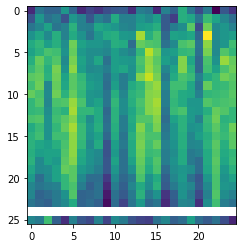

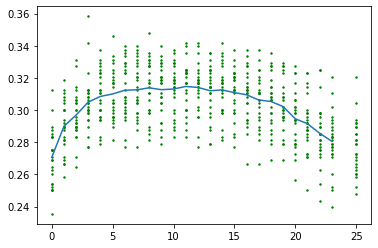

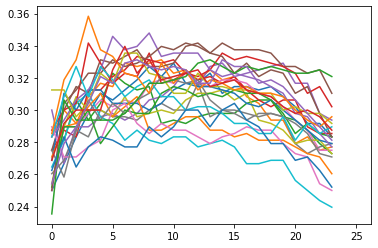

In [104]:
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.


# # plt.savefig('SummaryAccuracy.png')
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
# subjects=glob("./wang2014/[0,1]*")
# subjects=[subject.split("/")[-1] for subject in subjects]
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    except:
        pass

    for len_topN_1 in range(N-1,0,-1):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T
plt.imshow(GreedyBestAcc)
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# plt.ylim([0.19,0.36])
# plt.xlabel("number of ROIs")
# plt.ylabel("accuracy")


_=plt.figure()
for j in range(GreedyBestAcc.shape[1]):
    plt.plot(GreedyBestAcc[:,j])



In [5]:
from IPython.display import Image
 
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
 
from sklearn import datasets
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target  # 取species列，类别
# X = X[:99,:]
# y = y[:99]
print(f"X.shape={X.shape}") 

# train_test_split方法分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()  # 初始化一个对象sc去对数据集作变换
sc.fit(X_train)  # 用对象去拟合数据集X_train，并且存下来拟合参数
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


lr = LogisticRegression(C=1000.0, random_state=0)
# http://scikit-learn.org/stable/modules/generated/sklearn.lin ear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
lr.fit(X_train_std, y_train)
 
# 计算该预测实例点属于各类的概率
print(f"predict_proba={lr.predict_proba(X_test_std[0, :].reshape(1, -1))}")
# Output:array([[  2.05743774e-11,   6.31620264e-02,   9.36837974e-01]])
 
# 验证predict_proba的作用
c = lr.predict_proba(X_test_std[0, :].reshape(1, -1))
# c[0, 0] + c[0, 1] + c[0, 2]
# Output:0.99999999999999989
 
# 查看lr模型的特征系数
lr = LogisticRegression(C=1000.0, random_state=0)
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
lr.fit(X_train_std, y_train)
# print(lr.coef_)
# Output:[[-7.34015187 -6.64685581]
#        [ 2.54373335 -2.3421979 ]
#        [ 9.46617627  6.44380858]]
 
# 验证predict_proba工作原理
Zz = np.dot(lr.coef_, X_test_std[0, :].T) + lr.intercept_
print(Zz)
np.array(sigmoid(Zz)) / sum(np.array(sigmoid(Zz)))
# Output:array([  2.05743774e-11,   6.31620264e-02,   9.36837974e-01])
# 此结果就是预测实例点各类的概率

X.shape=(150, 2)
predict_proba=[[6.51335792e-16 4.95077314e-04 9.99504923e-01]]
[-20.77457363   6.58213611  14.19243752]


array([4.75321954e-10, 4.99654189e-01, 5.00345811e-01])

In [7]:
from IPython.display import Image
 
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
 
from sklearn import datasets
import numpy as np
 
iris = datasets.load_iris()
# http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
X = iris.data[:, [2, 3]]
print(X.shape)
y = iris.target  # 取species列，类别
 
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
 
# train_test_split方法分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
 
from sklearn.preprocessing import StandardScaler
 
sc = StandardScaler()  # 初始化一个对象sc去对数据集作变换
sc.fit(X_train)  # 用对象去拟合数据集X_train，并且存下来拟合参数
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
 
from sklearn.linear_model import LogisticRegression
 
 
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
 
 
lr = LogisticRegression(C=1000.0, random_state=0)
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
lr.fit(X_train_std, y_train)
 
# 计算该预测实例点属于各类的概率
print(lr.predict_proba(X_test_std[0, :].reshape(1, -1)))
# Output:array([[  2.05743774e-11,   6.31620264e-02,   9.36837974e-01]])
 
# 验证predict_proba的作用
c = lr.predict_proba(X_test_std[0, :].reshape(1, -1))
# c[0, 0] + c[0, 1] + c[0, 2]
# Output:0.99999999999999989
 
# 查看lr模型的特征系数
lr = LogisticRegression(C=1000.0, random_state=0)
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
lr.fit(X_train_std, y_train)
print(lr.coef_)
# Output:[[-7.34015187 -6.64685581]
#        [ 2.54373335 -2.3421979 ]
#        [ 9.46617627  6.44380858]]
 
# 验证predict_proba工作原理
Zz = np.dot(lr.coef_, X_test_std[0, :].T) + lr.intercept_
print(np.array(sigmoid(Zz)) / sum(np.array(sigmoid(Zz))))
# Output:array([  2.05743774e-11,   6.31620264e-02,   9.36837974e-01])
# 此结果就是预测实例点各类的概率

(150, 2)
[[6.51335792e-16 4.95077314e-04 9.99504923e-01]]
[[-8.2245993  -7.26261397]
 [-0.69739252  0.40062126]
 [ 8.92199181  6.86199271]]
[4.75321954e-10 4.99654189e-01 5.00345811e-01]


In [10]:
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
from rtCommon.cfg_loading import mkdir,cfg_loading
cfg = cfg_loading("sub001.ses4.toml")

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading,recognition_preprocess_2run,morphingTarget


'''
convert all dicom files into nii files in the temp dir. 
find the middle volume of the run1 as the template volume
align every other functional volume with templateFunctionalVolume (3dvolreg)
load behavior data and align with brain data
'''
# if not args.skipPre:
run_asTemplate=1 # which run in the realtime folder to select the middle volume as the template volume
recognition_preprocess_2run(cfg,run_asTemplate)

conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
toml filename=/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/projects/rtSynth_rt/conf/sub001.ses4.toml
running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses4/recognition/run1.nii  /tmp/1613759749.2199817/001_000001_000001_aligned.nii /tmp/1613759749.2199817/001_000001_000002_aligned.nii /tmp/1613759749.2199817/001_000001_000003_aligned.nii /tmp/1613759749.2199817/001_000001_000004_aligned.nii /tmp/1613759749.2199817/001_000001_000005_aligned.nii /tmp/1613759749.2199817/001_000001_000006_aligned.nii /tmp/1613759749.2199817/001_000001_000007_aligned.nii /tmp/1613759749.2199817/001_000001_000008_aligned.nii /tmp/1613759749.2199817/001_000001_000009_aligned.nii /tmp/1613759749.2199817/001_000001_000010_aligned.nii /tmp/1613759749.2199817/001_000001_000011_aligned.nii /tmp/1613759749.2199817/001_000001_000012_aligned.nii /tmp/1613759749.2199817/001_000001_000013_aligned.nii /

running fslmerge -t /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses4/recognition/run2.nii  /tmp/1613759749.2199817/001_000002_000001_aligned.nii /tmp/1613759749.2199817/001_000002_000002_aligned.nii /tmp/1613759749.2199817/001_000002_000003_aligned.nii /tmp/1613759749.2199817/001_000002_000004_aligned.nii /tmp/1613759749.2199817/001_000002_000005_aligned.nii /tmp/1613759749.2199817/001_000002_000006_aligned.nii /tmp/1613759749.2199817/001_000002_000007_aligned.nii /tmp/1613759749.2199817/001_000002_000008_aligned.nii /tmp/1613759749.2199817/001_000002_000009_aligned.nii /tmp/1613759749.2199817/001_000002_000010_aligned.nii /tmp/1613759749.2199817/001_000002_000011_aligned.nii /tmp/1613759749.2199817/001_000002_000012_aligned.nii /tmp/1613759749.2199817/001_000002_000013_aligned.nii /tmp/1613759749.2199817/001_000002_000014_aligned.nii /tmp/1613759749.2199817/001_000002_000015_aligned.nii /tmp/1613759749.2199817/001_000002_000016_aligned.nii /tmp/1613759749.219